In [27]:
import pandas as pd
import matplotlib.pyplot as plt


In [31]:
# --- RUN THIS CELL ONLY WHEN YOU NEED TO UPDATE THE DATA ---
import requests
from bs4 import BeautifulSoup

# Scrape standard stats
url_standard = "https://fbref.com/en/comps/11/10731/stats/2024-2025-Serie-A-Stats"
res = requests.get(url_standard)
soup = BeautifulSoup(res.text, 'lxml')
comments = soup.find_all(string=lambda text: isinstance(text, (str, bytes)) and 'table' in text)
target_comment = None
for c in comments:
    if 'id="stats_standard"' in c:
        target_comment = c
        break
if target_comment is not None:
    table_soup = BeautifulSoup(target_comment, 'lxml')
    table = table_soup.find('table')
    df_std = pd.read_html(str(table))[0]
else:
    raise Exception("Could not find stats_standard table in comments.")
df_std.columns = [
    '_'.join(col).strip().replace('Unnamed: ', '').replace('_level_0', '')
    if isinstance(col, tuple) else col
    for col in df_std.columns.values
]
rename_dict = {
    '0_Rk': 'Rk',
    '1_Player': 'Player',
    '2_Nation': 'Nation',
    '3_Pos': 'Pos',
    '4_Squad': 'Squad',
    '5_Age': 'Age',
    '6_Born': 'Born'
}
df_std = df_std.rename(columns=rename_dict)
df_std = df_std[df_std['Player'] != 'Player'].reset_index(drop=True)

# Scrape shooting stats
url_shoot = "https://fbref.com/en/comps/11/10731/shooting/2024-2025-Serie-A-Stats"
res = requests.get(url_shoot)
soup = BeautifulSoup(res.text, 'lxml')
comments = soup.find_all(string=lambda text: isinstance(text, (str, bytes)) and 'table' in text)
shooting_comment = None
for c in comments:
    if 'id="stats_shooting"' in c:
        shooting_comment = c
        break
if shooting_comment is not None:
    shooting_table_soup = BeautifulSoup(shooting_comment, 'lxml')
    shooting_table = shooting_table_soup.find('table')
    df_shoot = pd.read_html(str(shooting_table))[0]
else:
    raise Exception("Could not find stats_shooting table in comments.")
df_shoot.columns = [
    '_'.join(col).strip().replace('Unnamed: ', '').replace('_level_0', '')
    if isinstance(col, tuple) else col
    for col in df_shoot.columns.values
]
rename_dict_shoot = {
    '0_Rk': 'Rk',
    '1_Player': 'Player',
    '2_Nation': 'Nation',
    '3_Pos': 'Pos',
    '4_Squad': 'Squad',
    '5_Age': 'Age',
    '6_Born': 'Born'
}
df_shoot = df_shoot.rename(columns=rename_dict_shoot)
df_shoot = df_shoot[df_shoot['Player'] != 'Player'].reset_index(drop=True)

# Save locally
df_std.to_csv('seriea_standard_stats.csv', index=False)
df_shoot.to_csv('seriea_shooting_stats.csv', index=False)


In [32]:
df_std = pd.read_csv('seriea_standard_stats.csv')
df_shoot = pd.read_csv('seriea_shooting_stats.csv')


                  Player       Squad  Goals  Shots  Shot_Conversion   SoT_pct  \
101    Randal Kolo Muani    Juventus      8     25         0.320000  0.520000   
54           Assane Diao        Como      8     28         0.285714  0.464286   
171  Alexis Saelemaekers        Roma      7     25         0.280000  0.480000   
153                Pedro       Lazio     10     37         0.270270  0.432432   
170        Mateo Retegui    Atalanta     25     99         0.252525  0.323232   
81    Albert Guðmundsson  Fiorentina      6     25         0.240000  0.520000   
200         Timothy Weah    Juventus      5     21         0.238095  0.428571   
115        Romelu Lukaku      Napoli     14     60         0.233333  0.333333   
53           Boulaye Dia       Lazio      9     39         0.230769  0.487179   
79      Santiago Giménez       Milan      5     22         0.227273  0.409091   

     Goals_per90  
101     0.620690  
54      0.575080  
171     0.453564  
153     0.816697  
170     0.944

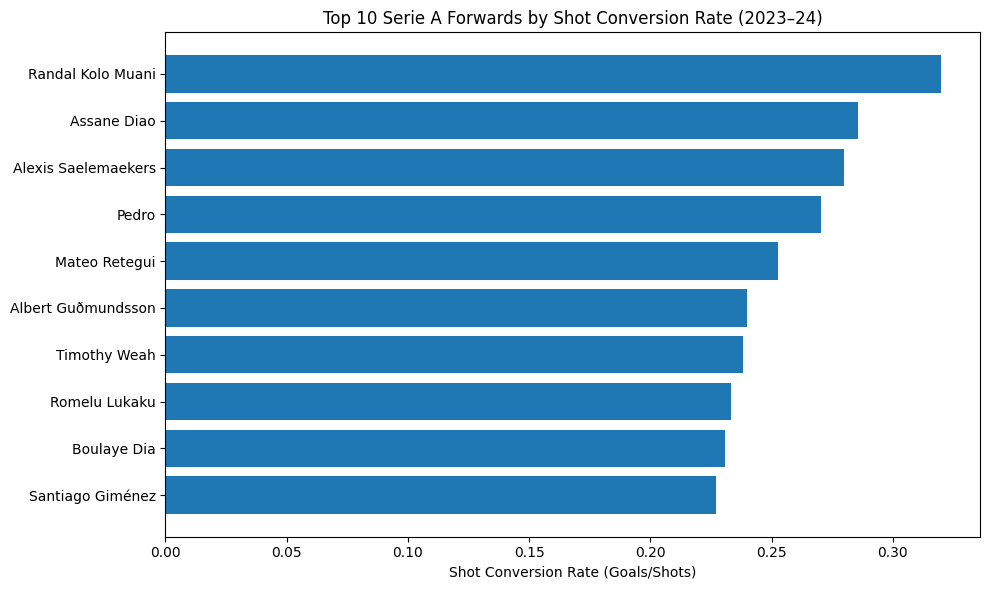

In [33]:
# Filter for forwards
df_fw = df_std[df_std['Pos'].str.contains('FW', na=False)].copy()

# Merge
df_merged = pd.merge(
    df_fw,
    df_shoot[['Player', 'Squad', 'Standard_Sh', 'Standard_SoT', 'Standard_Gls', 'Standard_PK', 'Standard_PKatt']],
    on=['Player', 'Squad'],
    how='left'
)

# Calculate metrics
df_merged['Min'] = pd.to_numeric(df_merged['Playing Time_Min'], errors='coerce')
df_merged['Goals'] = pd.to_numeric(df_merged['Performance_Gls'], errors='coerce')
df_merged['Shots'] = pd.to_numeric(df_merged['Standard_Sh'], errors='coerce')
df_merged['SoT'] = pd.to_numeric(df_merged['Standard_SoT'], errors='coerce')
df_merged['Goals_per90'] = df_merged['Goals'] / (df_merged['Min'] / 90)
df_merged['Shot_Conversion'] = df_merged['Goals'] / df_merged['Shots']
df_merged['SoT_pct'] = df_merged['SoT'] / df_merged['Shots']

# Top forwards by shot conversion rate
df_top_conversion = df_merged[df_merged['Shots'] >= 20].sort_values('Shot_Conversion', ascending=False)

print(df_top_conversion[['Player', 'Squad', 'Goals', 'Shots', 'Shot_Conversion', 'SoT_pct', 'Goals_per90']].head(10))

# Visualization
plt.figure(figsize=(10,6))
plt.barh(
    df_top_conversion.head(10)['Player'][::-1],
    df_top_conversion.head(10)['Shot_Conversion'][::-1]
)
plt.xlabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Top 10 Serie A Forwards by Shot Conversion Rate (2023–24)')
plt.tight_layout()
plt.show()


In [34]:
# Example: For each team, top forward by shot conversion (min 20 shots)
top_by_team = (
    df_top_conversion
    .sort_values(['Squad', 'Shot_Conversion'], ascending=[True, False])
    .groupby('Squad')
    .head(1)
)
print(top_by_team[['Squad', 'Player', 'Goals', 'Shots', 'Shot_Conversion', 'Goals_per90']])


             Squad               Player  Goals  Shots  Shot_Conversion  \
170       Atalanta        Mateo Retegui     25     99         0.252525   
149        Bologna    Riccardo Orsolini     15     72         0.208333   
159       Cagliari      Roberto Piccoli     10     97         0.103093   
54            Como          Assane Diao      8     28         0.285714   
66          Empoli  Sebastiano Esposito      8     59         0.135593   
81      Fiorentina   Albert Guðmundsson      6     25         0.240000   
161          Genoa     Andrea Pinamonti     10     78         0.128205   
177  Hellas Verona            Amin Sarr      4     23         0.173913   
192          Inter        Marcus Thuram     14     64         0.218750   
101       Juventus    Randal Kolo Muani      8     25         0.320000   
153          Lazio                Pedro     10     37         0.270270   
160          Lecce    Santiago Pierotti      4     32         0.125000   
79           Milan     Santiago Giméne

In [35]:
team_name = "Inter"  # Replace with any team, or loop through df_top_conversion['Squad'].unique()
print(
    df_top_conversion[df_top_conversion['Squad'] == team_name]
    [['Player', 'Goals', 'Shots', 'Shot_Conversion', 'Goals_per90']]
    .sort_values('Shot_Conversion', ascending=False)
)


               Player  Goals  Shots  Shot_Conversion  Goals_per90
192     Marcus Thuram     14     64         0.218750     0.572727
60    Denzel Dumfries      7     36         0.194444     0.337802
124  Lautaro Martínez     12     99         0.121212     0.436540
55   Federico Dimarco      4     55         0.072727     0.168224


In [38]:
# Mean conversion per team
team_summary = (
    df_top_conversion
    .groupby('Squad')
    .agg(
        Num_Forwards=('Player', 'count'),
        Total_Goals=('Goals', 'sum'),
        Avg_Shot_Conv=('Shot_Conversion', 'mean'),
        Avg_Goals_per90=('Goals_per90', 'mean')
    )
    .sort_values('Avg_Shot_Conv', ascending=False)
)
print(team_summary)


               Num_Forwards  Total_Goals  Avg_Shot_Conv  Avg_Goals_per90
Squad                                                                   
Atalanta                  3           47       0.194515         0.616446
Roma                      5           30       0.158462         0.343528
Inter                     4           37       0.151783         0.378823
Lazio                     6           42       0.147957         0.355600
Juventus                  7           39       0.146133         0.307624
Fiorentina                5           31       0.141675         0.296888
Bologna                   6           43       0.136098         0.348345
Milan                     7           35       0.135765         0.330242
Napoli                    5           30       0.120154         0.310272
Monza                     4           15       0.119257         0.216905
Como                      5           28       0.116274         0.268949
Torino                    4           17       0.11

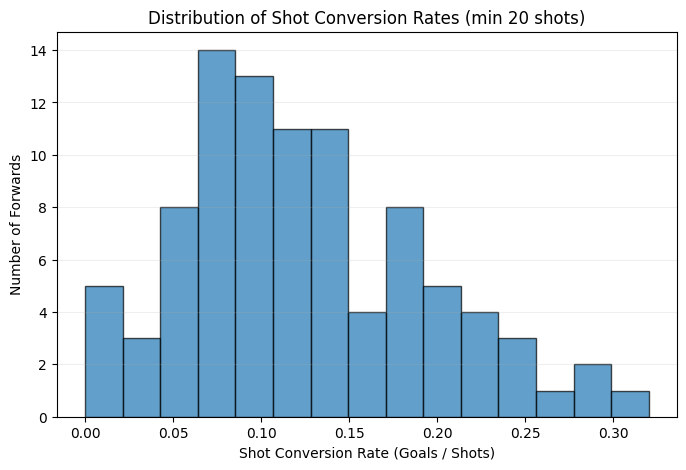

In [39]:
plt.figure(figsize=(8, 5))
plt.hist(df_top_conversion['Shot_Conversion'].dropna(), bins=15, edgecolor='black', alpha=0.7)
plt.xlabel('Shot Conversion Rate (Goals / Shots)')
plt.ylabel('Number of Forwards')
plt.title('Distribution of Shot Conversion Rates (min 20 shots)')
plt.grid(axis='y', alpha=0.2)
plt.show()


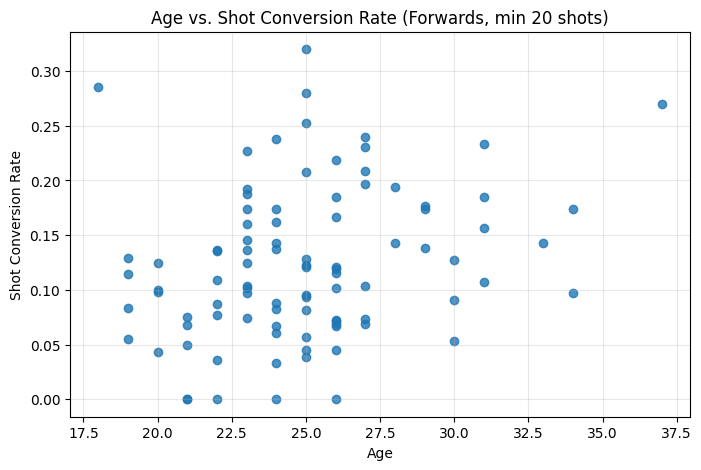

Correlation between Age and Shot Conversion: 0.27


In [40]:
# Convert Age to numeric if not already
df_top_conversion['Age'] = pd.to_numeric(df_top_conversion['Age'], errors='coerce')

plt.figure(figsize=(8,5))
plt.scatter(df_top_conversion['Age'], df_top_conversion['Shot_Conversion'], alpha=0.8)
plt.xlabel('Age')
plt.ylabel('Shot Conversion Rate')
plt.title('Age vs. Shot Conversion Rate (Forwards, min 20 shots)')
plt.grid(alpha=0.3)
plt.show()

# Optional: Add correlation
corr = df_top_conversion[['Age', 'Shot_Conversion']].corr().iloc[0,1]
print(f'Correlation between Age and Shot Conversion: {corr:.2f}')


Top 10 overperformers by Goals vs xG:
                  Player     Squad  Goals    xG  xG_diff
170        Mateo Retegui  Atalanta     25  18.9      6.1
149    Riccardo Orsolini   Bologna     15  10.1      4.9
153                Pedro     Lazio     10   5.3      4.7
113      Ademola Lookman  Atalanta     15  10.3      4.7
171  Alexis Saelemaekers      Roma      7   2.5      4.5
114        Lorenzo Lucca   Udinese     12   7.6      4.4
192        Marcus Thuram     Inter     14   9.9      4.1
54           Assane Diao      Como      8   4.0      4.0
101    Randal Kolo Muani  Juventus      8   4.7      3.3
202         Kenan Yıldız  Juventus      7   4.3      2.7
Top 10 underperformers by Goals vs xG:
                   Player       Squad  Goals    xG  xG_diff
1           Tammy Abraham       Milan      3   7.1     -4.1
33   Valentín Castellanos       Lazio     10  13.4     -3.4
18        Ange-Yoan Bonny       Parma      6   9.4     -3.4
152           Nicolás Paz        Como      6   9.3     -

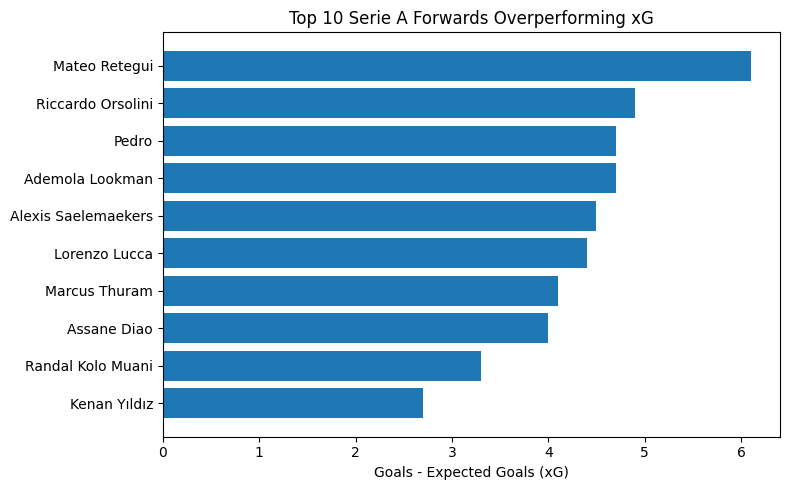

In [41]:
# Compute xG difference (actual - expected)
df_top_conversion['xG'] = pd.to_numeric(df_top_conversion['Expected_xG'], errors='coerce')
df_top_conversion['xG_diff'] = df_top_conversion['Goals'] - df_top_conversion['xG']

# Top 10 overperformers
print("Top 10 overperformers by Goals vs xG:")
print(df_top_conversion.sort_values('xG_diff', ascending=False)[['Player', 'Squad', 'Goals', 'xG', 'xG_diff']].head(10))

# Top 10 underperformers
print("Top 10 underperformers by Goals vs xG:")
print(df_top_conversion.sort_values('xG_diff')[['Player', 'Squad', 'Goals', 'xG', 'xG_diff']].head(10))

# Visualize
plt.figure(figsize=(8,5))
plt.barh(df_top_conversion.sort_values('xG_diff', ascending=False).head(10)['Player'][::-1],
         df_top_conversion.sort_values('xG_diff', ascending=False).head(10)['xG_diff'][::-1])
plt.xlabel('Goals - Expected Goals (xG)')
plt.title('Top 10 Serie A Forwards Overperforming xG')
plt.tight_layout()
plt.show()


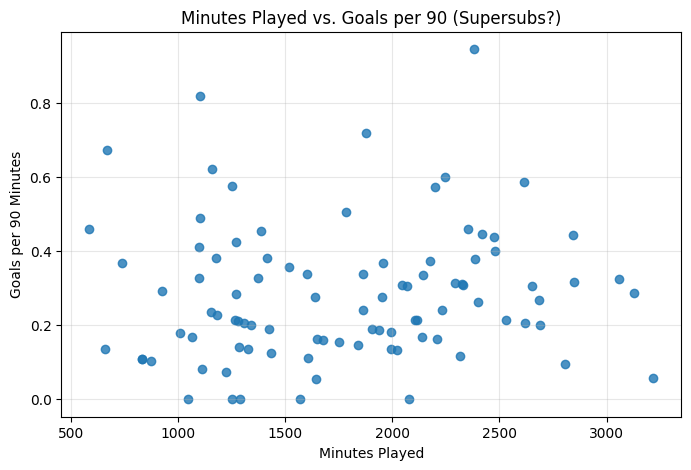

Potential supersubs:
              Player  Squad  Min  Goals_per90  Goals
79  Santiago Giménez  Milan  669     0.672646      5


In [42]:
plt.figure(figsize=(8,5))
plt.scatter(df_top_conversion['Min'], df_top_conversion['Goals_per90'], alpha=0.8)
plt.xlabel('Minutes Played')
plt.ylabel('Goals per 90 Minutes')
plt.title('Minutes Played vs. Goals per 90 (Supersubs?)')
plt.grid(alpha=0.3)
plt.show()

# Highlight players with <1000 minutes and high Goals_per90 (possible supersubs)
supersubs = df_top_conversion[(df_top_conversion['Min'] < 1000) & (df_top_conversion['Goals_per90'] > 0.5)]
print("Potential supersubs:")
print(supersubs[['Player', 'Squad', 'Min', 'Goals_per90', 'Goals']])


Top 10 forwards by goal involvement per 90:
                Player     Squad  Goals  Ast  Goal_Involvement_per90
170      Mateo Retegui  Atalanta     25    8                1.246328
79    Santiago Giménez     Milan      5    2                0.941704
149  Riccardo Orsolini   Bologna     15    4                0.910543
153              Pedro     Lazio     10    1                0.898367
113    Ademola Lookman  Atalanta     15    5                0.801068
115      Romelu Lukaku    Napoli     14   10                0.759761
192      Marcus Thuram     Inter     14    4                0.736364
166  Christian Pulisic     Milan     11    9                0.726392
197     Dušan Vlahović  Juventus     10    4                0.706278
101  Randal Kolo Muani  Juventus      8    1                0.698276


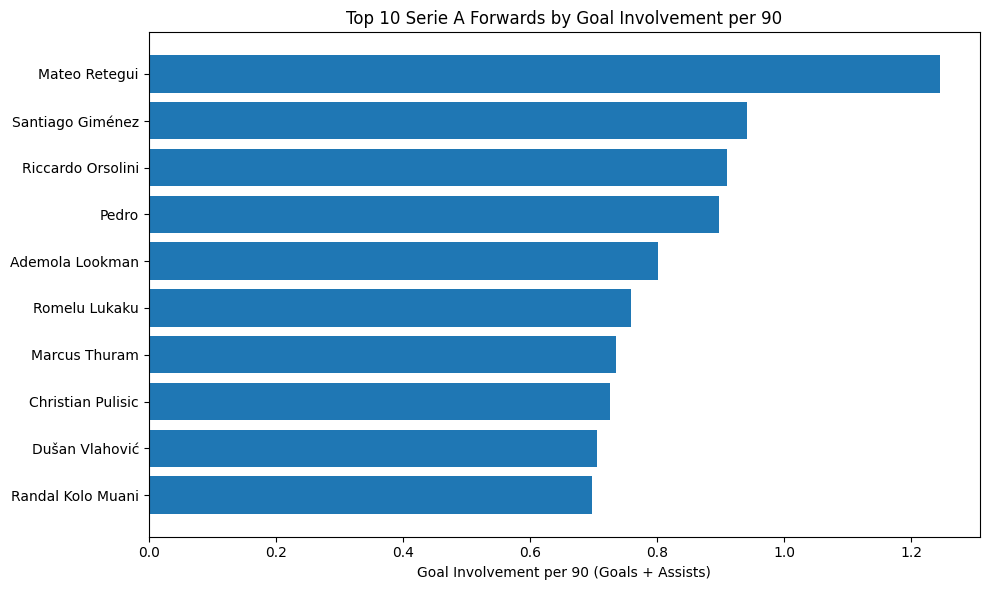

In [43]:
df_top_conversion['Ast'] = pd.to_numeric(df_top_conversion['Performance_Ast'], errors='coerce')
df_top_conversion['Goal_Involvement_per90'] = (df_top_conversion['Goals'] + df_top_conversion['Ast']) / (df_top_conversion['Min'] / 90)

print("Top 10 forwards by goal involvement per 90:")
print(
    df_top_conversion.sort_values('Goal_Involvement_per90', ascending=False)
    [['Player', 'Squad', 'Goals', 'Ast', 'Goal_Involvement_per90']]
    .head(10)
)

# Plot
plt.figure(figsize=(10,6))
plt.barh(
    df_top_conversion.sort_values('Goal_Involvement_per90', ascending=False).head(10)['Player'][::-1],
    df_top_conversion.sort_values('Goal_Involvement_per90', ascending=False).head(10)['Goal_Involvement_per90'][::-1]
)
plt.xlabel('Goal Involvement per 90 (Goals + Assists)')
plt.title('Top 10 Serie A Forwards by Goal Involvement per 90')
plt.tight_layout()
plt.show()


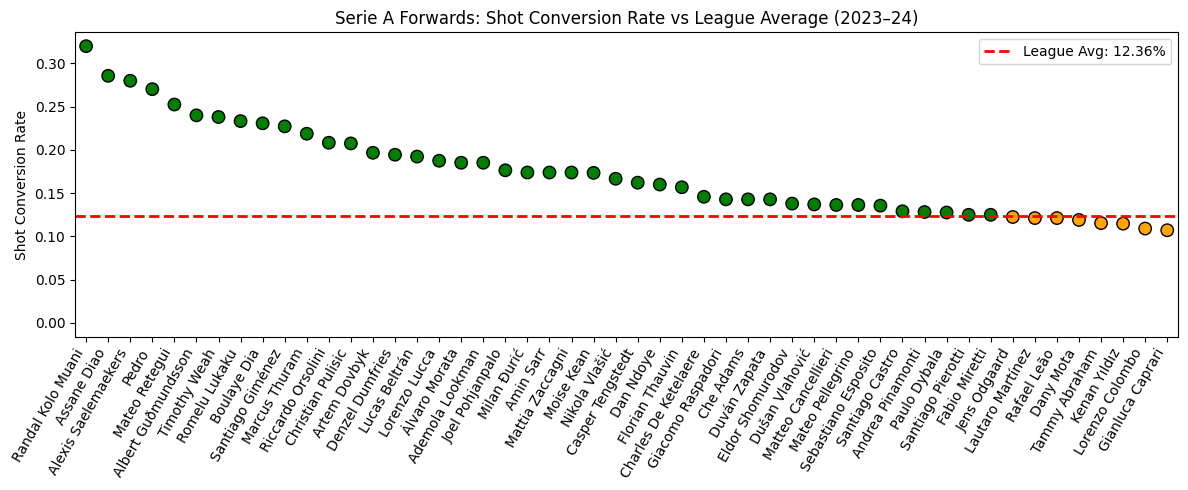

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate league average shot conversion for forwards with min 20 shots
league_avg = df_top_conversion['Shot_Conversion'].mean()

# Sort players for plotting
sorted_df = df_top_conversion.sort_values('Shot_Conversion', ascending=False).reset_index(drop=True)

# Assign colors: green if above or equal to average, orange if below
colors = np.where(sorted_df['Shot_Conversion'] >= league_avg, 'green', 'orange')

# Plot
plt.figure(figsize=(12, 5))
plt.scatter(
    range(len(sorted_df)),
    sorted_df['Shot_Conversion'],
    c=colors,
    s=80,
    edgecolor='k'
)
plt.axhline(league_avg, color='red', linestyle='--', linewidth=2, label=f'League Avg: {league_avg:.2%}')

# Optionally, label top N players on the x-axis
topN = 50
plt.xticks(
    ticks=range(topN),
    labels=sorted_df['Player'].head(topN),
    rotation=60,
    ha='right'
)
plt.xlim(-0.5, topN - 0.5)

plt.ylabel('Shot Conversion Rate')
plt.title('Serie A Forwards: Shot Conversion Rate vs League Average (2023–24)')
plt.legend()
plt.tight_layout()
plt.show()


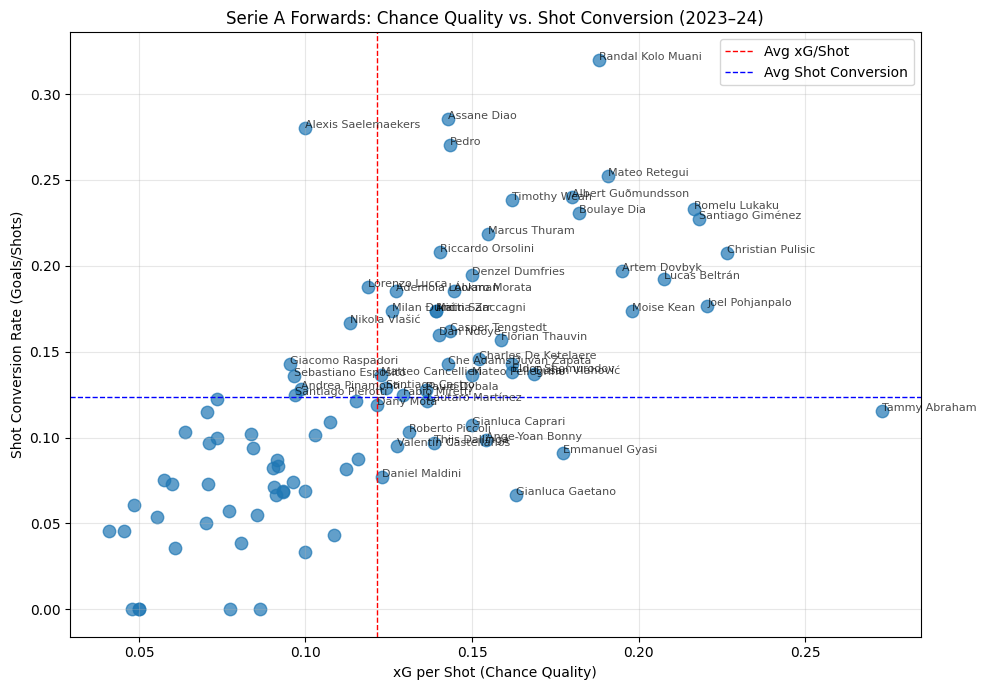

In [47]:
import matplotlib.pyplot as plt

# Calculate xG per shot (chance quality)
df_top_conversion['xG_per_shot'] = df_top_conversion['xG'] / df_top_conversion['Shots']

plt.figure(figsize=(10, 7))
plt.scatter(df_top_conversion['xG_per_shot'], df_top_conversion['Shot_Conversion'], s=80, alpha=0.7)

# Highlight player names for those in the "corners" (optional: tune thresholds)
for i, row in df_top_conversion.iterrows():
    if (
        (row['xG_per_shot'] > df_top_conversion['xG_per_shot'].mean() and row['Shot_Conversion'] > df_top_conversion['Shot_Conversion'].mean())
        or (row['xG_per_shot'] > df_top_conversion['xG_per_shot'].mean() and row['Shot_Conversion'] < df_top_conversion['Shot_Conversion'].mean())
        or (row['xG_per_shot'] < df_top_conversion['xG_per_shot'].mean() and row['Shot_Conversion'] > df_top_conversion['Shot_Conversion'].mean())
    ):
        plt.text(row['xG_per_shot'], row['Shot_Conversion'], row['Player'], fontsize=8, alpha=0.7)

plt.axvline(df_top_conversion['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_top_conversion['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')

plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Forwards: Chance Quality vs. Shot Conversion (2023–24)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [48]:
# Determine average
mean_xg_shot = df_top_conversion['xG_per_shot'].mean()
mean_conv = df_top_conversion['Shot_Conversion'].mean()

def finishing_group(row):
    if row['xG_per_shot'] >= mean_xg_shot and row['Shot_Conversion'] >= mean_conv:
        return 'Elite: Great Chances & Finishing'
    elif row['xG_per_shot'] >= mean_xg_shot:
        return 'Wasteful: Great Chances, Poor Finishing'
    elif row['Shot_Conversion'] >= mean_conv:
        return 'Clinical: Poor Chances, Great Finishing'
    else:
        return 'Ineffective: Poor Chances & Finishing'

df_top_conversion['Finishing_Type'] = df_top_conversion.apply(finishing_group, axis=1)


In [50]:
print(df_top_conversion[['Player', 'Squad', 'xG_per_shot', 'Shot_Conversion', 'Finishing_Type']].sort_values('Finishing_Type'))

                   Player    Squad  xG_per_shot  Shot_Conversion  \
199         Nikola Vlašić   Torino     0.113333         0.166667   
171   Alexis Saelemaekers     Roma     0.100000         0.280000   
160     Santiago Pierotti    Lecce     0.096875         0.125000   
161      Andrea Pinamonti    Genoa     0.098718         0.128205   
66    Sebastiano Esposito   Empoli     0.096610         0.135593   
..                    ...      ...          ...              ...   
48         Thijs Dallinga  Bologna     0.138710         0.096774   
33   Valentín Castellanos    Lazio     0.127619         0.095238   
82         Emmanuel Gyasi   Empoli     0.177273         0.090909   
30       Gianluca Caprari    Monza     0.150000         0.107143   
1           Tammy Abraham    Milan     0.273077         0.115385   

                              Finishing_Type  
199  Clinical: Poor Chances, Great Finishing  
171  Clinical: Poor Chances, Great Finishing  
160  Clinical: Poor Chances, Great Finishi

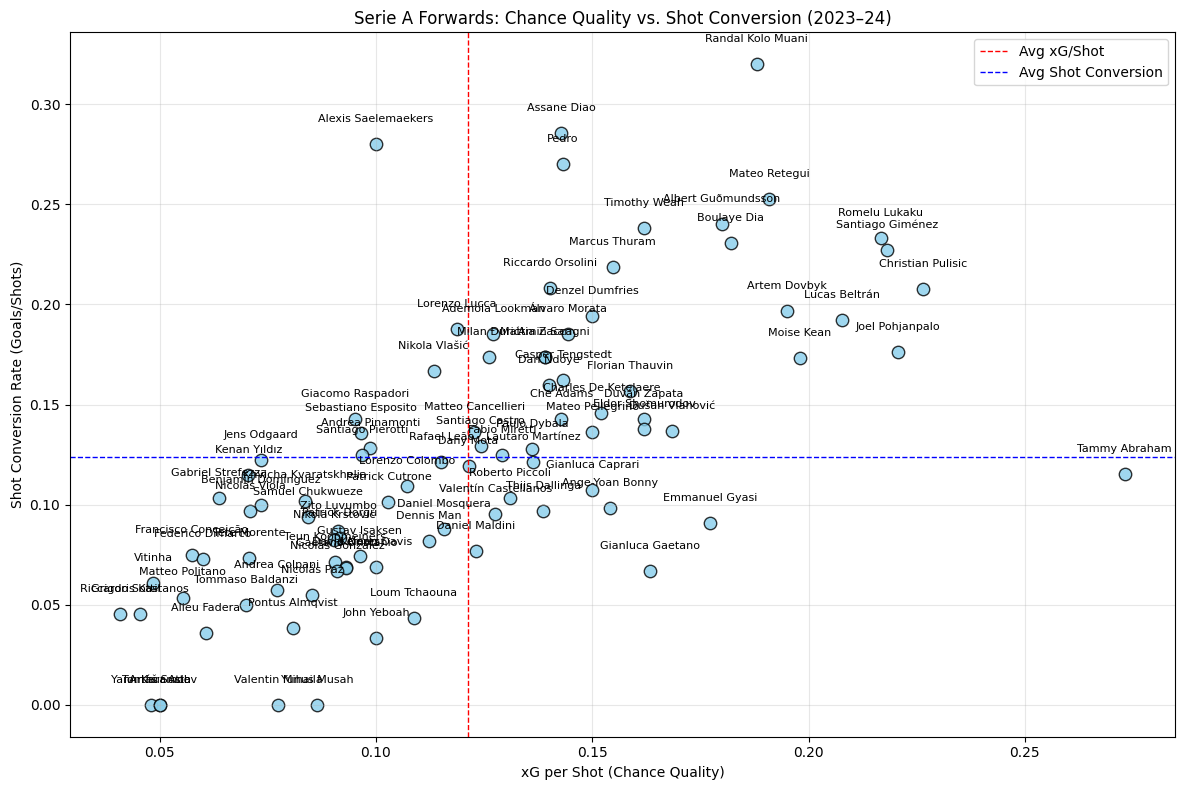

In [51]:
import matplotlib.pyplot as plt

# Calculate xG per shot
df_top_conversion['xG_per_shot'] = df_top_conversion['xG'] / df_top_conversion['Shots']

plt.figure(figsize=(12, 8))
plt.scatter(df_top_conversion['xG_per_shot'], df_top_conversion['Shot_Conversion'], s=80, alpha=0.8, color='skyblue', edgecolor='k')

# Annotate every player slightly above their dot
for i, row in df_top_conversion.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.01,  # vertical offset, tweak as needed
        row['Player'],
        fontsize=8,
        ha='center',
        va='bottom'
    )

# Add average lines
plt.axvline(df_top_conversion['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_top_conversion['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')

plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Forwards: Chance Quality vs. Shot Conversion (2023–24)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


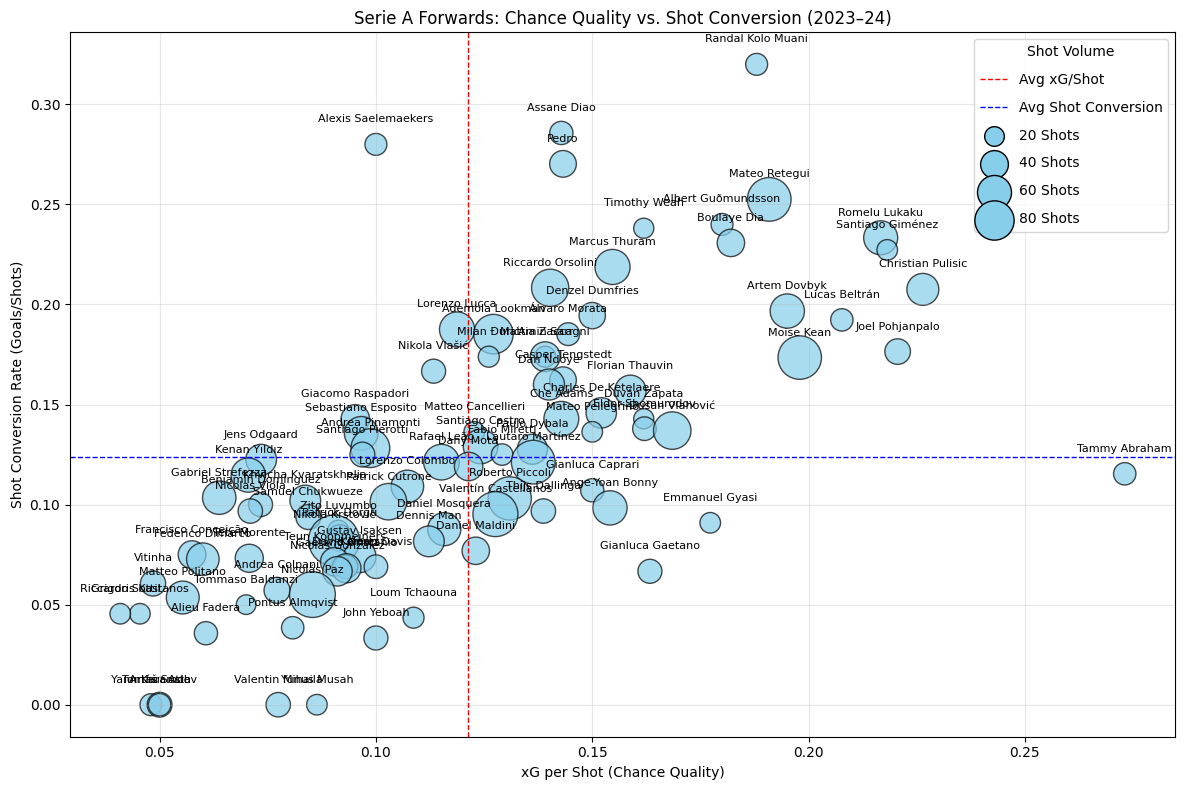

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate xG per shot if not already present
df_top_conversion['xG_per_shot'] = df_top_conversion['xG'] / df_top_conversion['Shots']

plt.figure(figsize=(12, 8))

# Scale shot volume for better visibility in plot (adjust 10 as needed)
sizes = df_top_conversion['Shots'].fillna(0) * 10

scatter = plt.scatter(
    df_top_conversion['xG_per_shot'],
    df_top_conversion['Shot_Conversion'],
    s=sizes,
    alpha=0.7,
    c='skyblue',
    edgecolor='k'
)

# Annotate EVERY player above their dot
for i, row in df_top_conversion.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.01,
        row['Player'],
        fontsize=8,
        ha='center',
        va='bottom'
    )

# Draw average lines
plt.axvline(df_top_conversion['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_top_conversion['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')

plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Forwards: Chance Quality vs. Shot Conversion (2023–24)')
plt.legend()
plt.grid(alpha=0.3)

# Add shot volume legend
for shots in [20, 40, 60, 80]:
    plt.scatter([], [], s=shots*10, c='skyblue', edgecolor='k', label=f'{shots} Shots')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Shot Volume')

plt.tight_layout()
plt.show()


In [57]:
df_top_conversion[df_top_conversion['Player'] == 'Alexis Saelemaekers']['Goals']

171    7
Name: Goals, dtype: int64

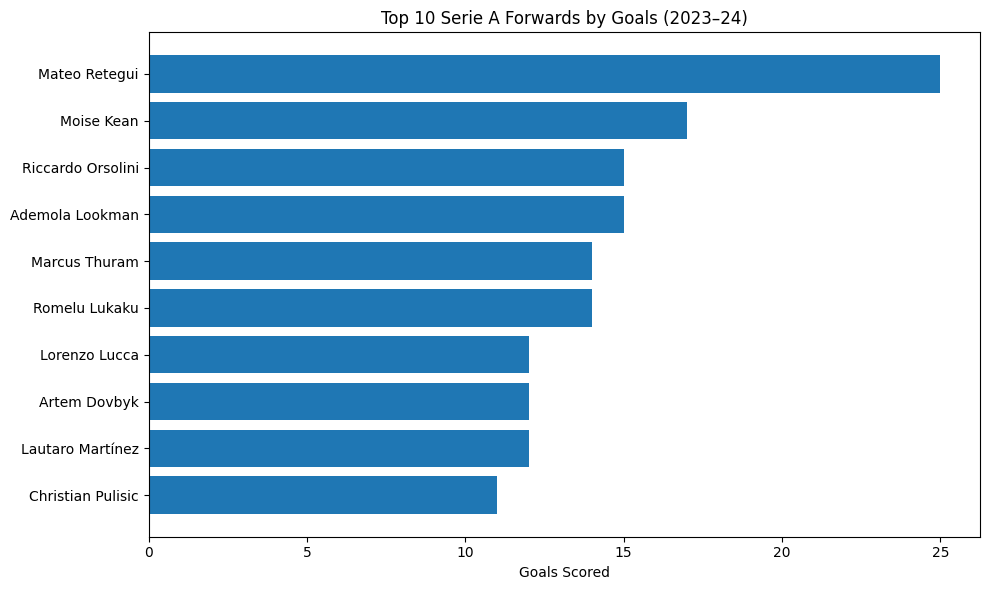

In [58]:
import matplotlib.pyplot as plt

# Sort by goals scored and select top N (e.g., top 10)
top_goal_scorers = df_top_conversion.sort_values('Goals', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(
    top_goal_scorers['Player'][::-1],   # Reverse for highest at top
    top_goal_scorers['Goals'][::-1]
)
plt.xlabel('Goals Scored')
plt.title('Top 10 Serie A Forwards by Goals (2023–24)')
plt.tight_layout()
plt.show()


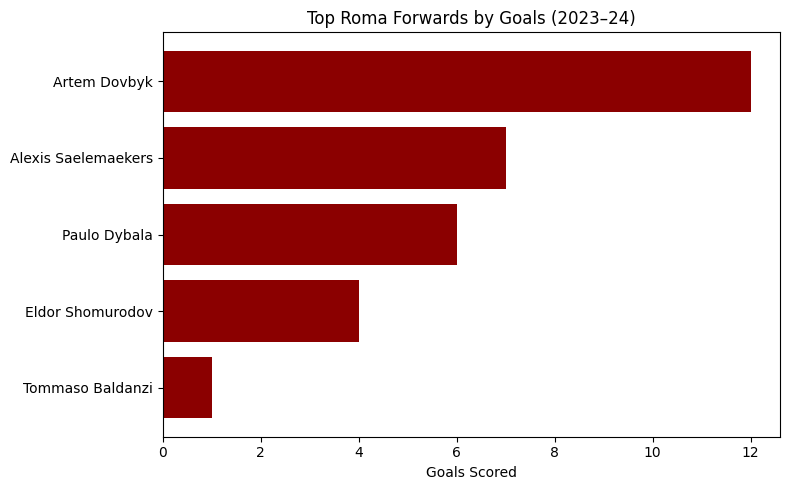

In [59]:
import matplotlib.pyplot as plt

# Filter for Roma players only
roma_forwards = df_top_conversion[df_top_conversion['Squad'] == 'Roma']

# Sort by goals and select top N (all, or top 5/10 if you prefer)
top_roma_scorers = roma_forwards.sort_values('Goals', ascending=False).head(10)

plt.figure(figsize=(8, 5))
plt.barh(
    top_roma_scorers['Player'][::-1],
    top_roma_scorers['Goals'][::-1],
    color='darkred'
)
plt.xlabel('Goals Scored')
plt.title('Top Roma Forwards by Goals (2023–24)')
plt.tight_layout()
plt.show()


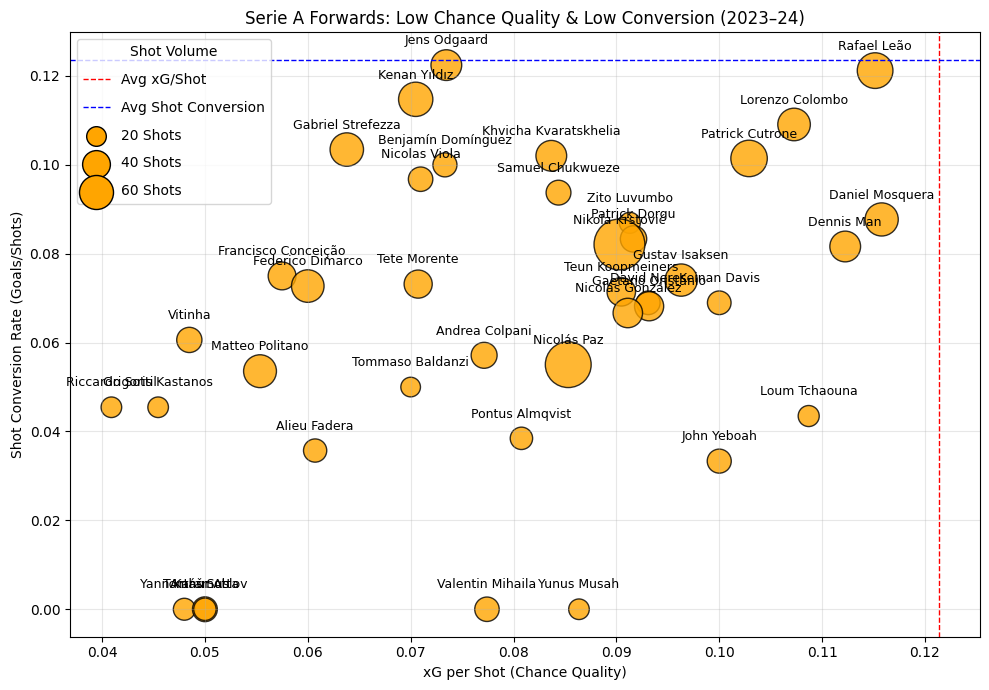

In [61]:
import matplotlib.pyplot as plt

# Calculate averages
mean_xg_per_shot = df_top_conversion['xG_per_shot'].mean()
mean_conversion = df_top_conversion['Shot_Conversion'].mean()

# Filter for bottom left quadrant
bottom_left = df_top_conversion[
    (df_top_conversion['xG_per_shot'] < mean_xg_per_shot) &
    (df_top_conversion['Shot_Conversion'] < mean_conversion)
]

plt.figure(figsize=(10, 7))
sizes = bottom_left['Shots'].fillna(0) * 10

plt.scatter(
    bottom_left['xG_per_shot'],
    bottom_left['Shot_Conversion'],
    s=sizes,
    alpha=0.8,
    c='orange',
    edgecolor='k'
)

for i, row in bottom_left.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.004,   # <--- smaller offset
        row['Player'],
        fontsize=9,
        ha='center',
        va='bottom'
    )

plt.axvline(mean_xg_per_shot, color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(mean_conversion, color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')

plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Forwards: Low Chance Quality & Low Conversion (2023–24)')
plt.legend()
plt.grid(alpha=0.3)

# Add shot volume legend
for shots in [20, 40, 60]:
    plt.scatter([], [], s=shots*10, c='orange', edgecolor='k', label=f'{shots} Shots')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Shot Volume')

plt.tight_layout()
plt.show()


In [62]:
milan_forwards = df_top_conversion[df_top_conversion['Squad'] == 'Milan'].copy()


In [63]:
milan_forwards['xG_per_shot'] = milan_forwards['xG'] / milan_forwards['Shots']


In [64]:
mean_xg_per_shot_milan = milan_forwards['xG_per_shot'].mean()
mean_conversion_milan = milan_forwards['Shot_Conversion'].mean()


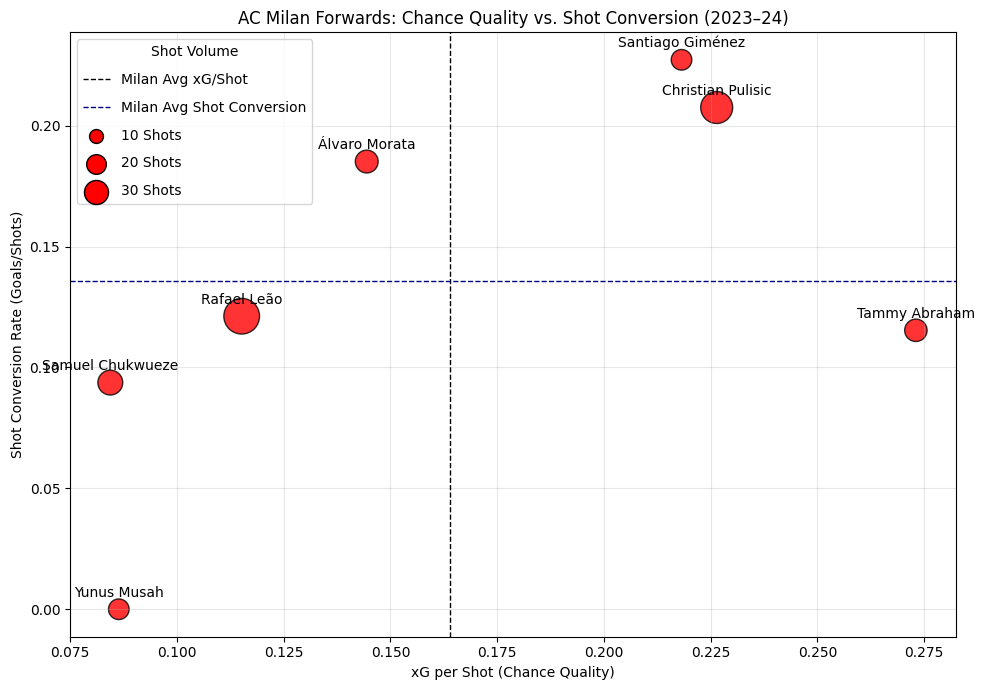

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sizes = milan_forwards['Shots'].fillna(0) * 10

plt.scatter(
    milan_forwards['xG_per_shot'],
    milan_forwards['Shot_Conversion'],
    s=sizes,
    alpha=0.8,
    c='red',
    edgecolor='k'
)

# Annotate every Milan forward
for i, row in milan_forwards.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.004,
        row['Player'],
        fontsize=10,
        ha='center',
        va='bottom'
    )

# Draw Milan-only average lines
plt.axvline(mean_xg_per_shot_milan, color='black', linestyle='--', linewidth=1, label='Milan Avg xG/Shot')
plt.axhline(mean_conversion_milan, color='navy', linestyle='--', linewidth=1, label='Milan Avg Shot Conversion')

plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('AC Milan Forwards: Chance Quality vs. Shot Conversion (2023–24)')
plt.legend()
plt.grid(alpha=0.3)

# Shot volume legend
for shots in [10, 20, 30]:
    plt.scatter([], [], s=shots*10, c='red', edgecolor='k', label=f'{shots} Shots')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Shot Volume')

plt.tight_layout()
plt.show()


In [66]:
print(
    milan_forwards[['Player', 'Shots', 'xG_per_shot', 'Shot_Conversion', 'Goals', 'xG', 'Min', 'Goals_per90']]
    .sort_values('Goals', ascending=False)
)


                Player  Shots  xG_per_shot  Shot_Conversion  Goals    xG  \
166  Christian Pulisic     53     0.226415         0.207547     11  12.0   
111        Rafael Leão     66     0.115152         0.121212      8   7.6   
79    Santiago Giménez     22     0.218182         0.227273      5   4.8   
131      Álvaro Morata     27     0.144444         0.185185      5   3.9   
1        Tammy Abraham     26     0.273077         0.115385      3   7.1   
39    Samuel Chukwueze     32     0.084375         0.093750      3   2.7   
135        Yunus Musah     22     0.086364         0.000000      0   1.9   

      Min  Goals_per90  
166  2478     0.399516  
111  2323     0.309944  
79    669     0.672646  
131  1099     0.409463  
1    1183     0.228233  
39    925     0.291892  
135  1571     0.000000  


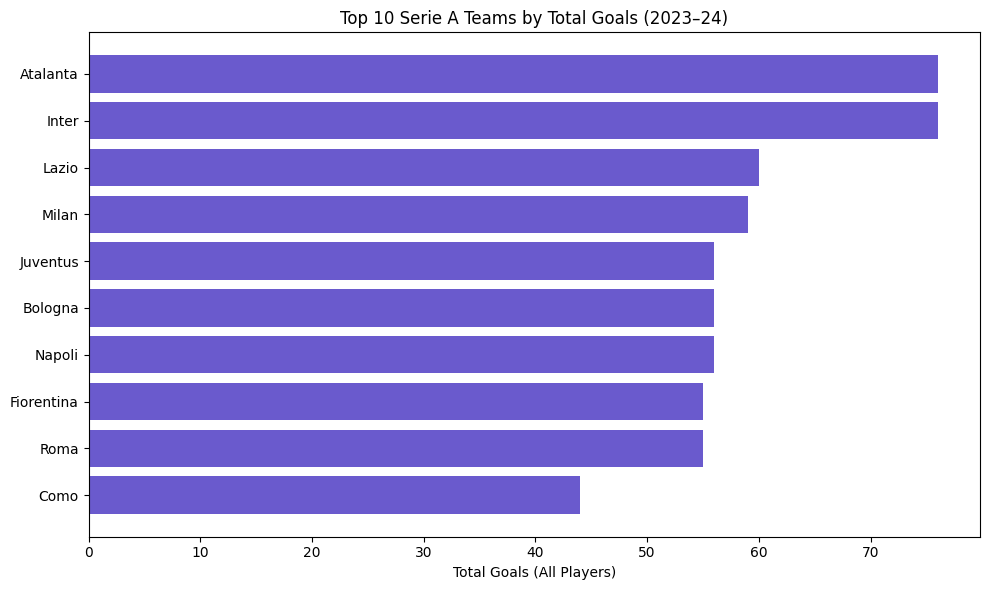

In [68]:
import matplotlib.pyplot as plt

# Make sure 'Performance_Gls' is numeric
df_std['Performance_Gls'] = pd.to_numeric(df_std['Performance_Gls'], errors='coerce')

# Group by squad, sum goals
team_goals_all = (
    df_std.groupby('Squad')['Performance_Gls'].sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
plt.barh(team_goals_all.index[::-1], team_goals_all.values[::-1], color='slateblue')
plt.xlabel('Total Goals (All Players)')
plt.title('Top 10 Serie A Teams by Total Goals (2023–24)')
plt.tight_layout()
plt.show()


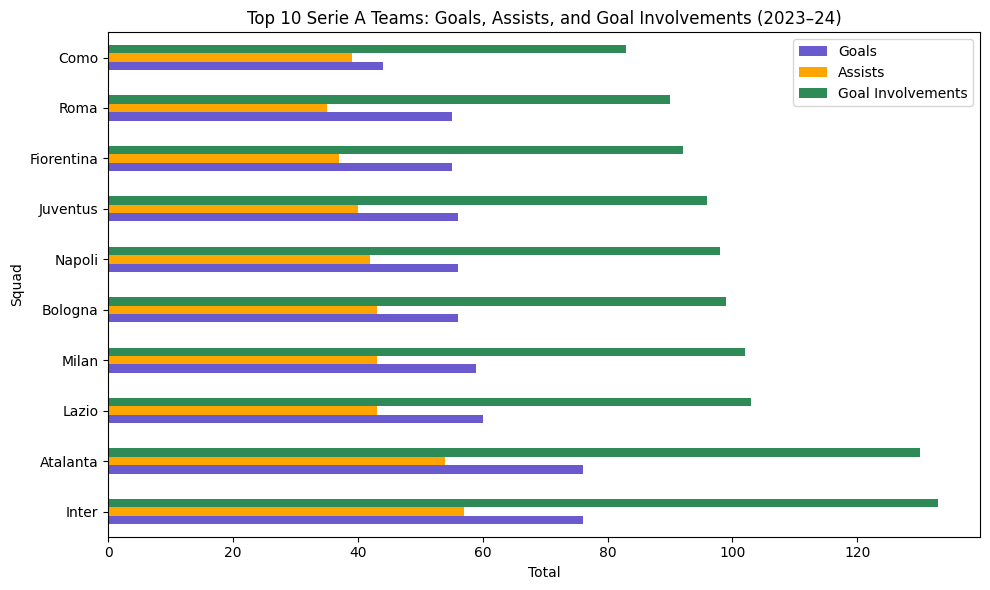

In [69]:
# Make sure assists are numeric
df_std['Performance_Ast'] = pd.to_numeric(df_std['Performance_Ast'], errors='coerce')
df_std['Performance_Gls'] = pd.to_numeric(df_std['Performance_Gls'], errors='coerce')

# Total goal involvements per team
team_involvement = (
    df_std.groupby('Squad').apply(
        lambda x: pd.Series({
            'Goals': x['Performance_Gls'].sum(),
            'Assists': x['Performance_Ast'].sum(),
            'Goal Involvements': x['Performance_Gls'].sum() + x['Performance_Ast'].sum()
        })
    )
    .sort_values('Goal Involvements', ascending=False)
    .head(10)
)

team_involvement[['Goals', 'Assists', 'Goal Involvements']].plot(
    kind='barh', figsize=(10,6), color=['slateblue', 'orange', 'seagreen']
)
plt.xlabel('Total')
plt.title('Top 10 Serie A Teams: Goals, Assists, and Goal Involvements (2023–24)')
plt.tight_layout()
plt.show()


                     Top Scorer  Total Goals  Top Scorer Goals  Top Scorer %
Squad                                                                       
Lecce           Nikola Krstović           27                11      0.407407
Atalanta          Mateo Retegui           76                25      0.328947
Fiorentina           Moise Kean           55                17      0.309091
Udinese           Lorenzo Lucca           41                12      0.292683
Genoa          Andrea Pinamonti           35                10      0.285714
Bologna       Riccardo Orsolini           56                15      0.267857
Cagliari        Roberto Piccoli           38                10      0.263158
Empoli      Sebastiano Esposito           31                 8      0.258065
Torino                Che Adams           36                 9      0.250000
Napoli            Romelu Lukaku           56                14      0.250000


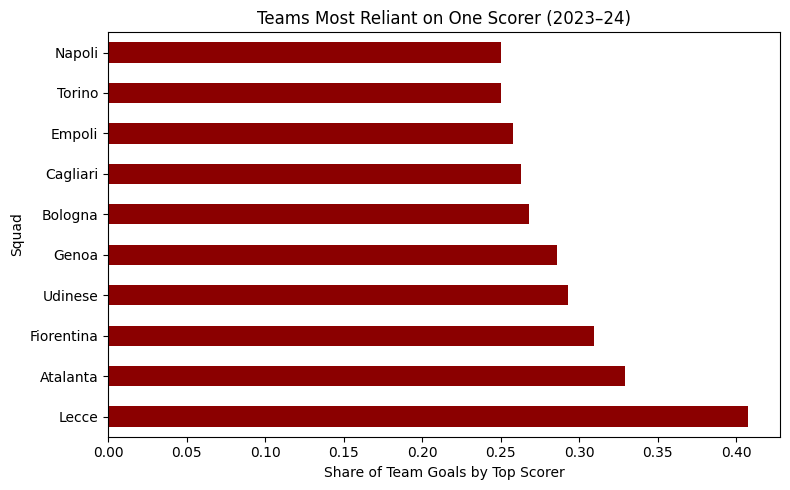

In [70]:
# For each team, find top scorer and their share
top_scorer_share = (
    df_std.groupby('Squad').apply(
        lambda x: pd.Series({
            'Total Goals': x['Performance_Gls'].sum(),
            'Top Scorer': x.loc[x['Performance_Gls'].idxmax(), 'Player'],
            'Top Scorer Goals': x['Performance_Gls'].max()
        })
    )
)
top_scorer_share['Top Scorer %'] = top_scorer_share['Top Scorer Goals'] / top_scorer_share['Total Goals']

# Show top 10 by top scorer share
top10_share = top_scorer_share.sort_values('Top Scorer %', ascending=False).head(10)
print(top10_share[['Top Scorer', 'Total Goals', 'Top Scorer Goals', 'Top Scorer %']])

top10_share['Top Scorer %'].plot(kind='barh', figsize=(8,5), color='darkred')
plt.xlabel('Share of Team Goals by Top Scorer')
plt.title('Teams Most Reliant on One Scorer (2023–24)')
plt.tight_layout()
plt.show()


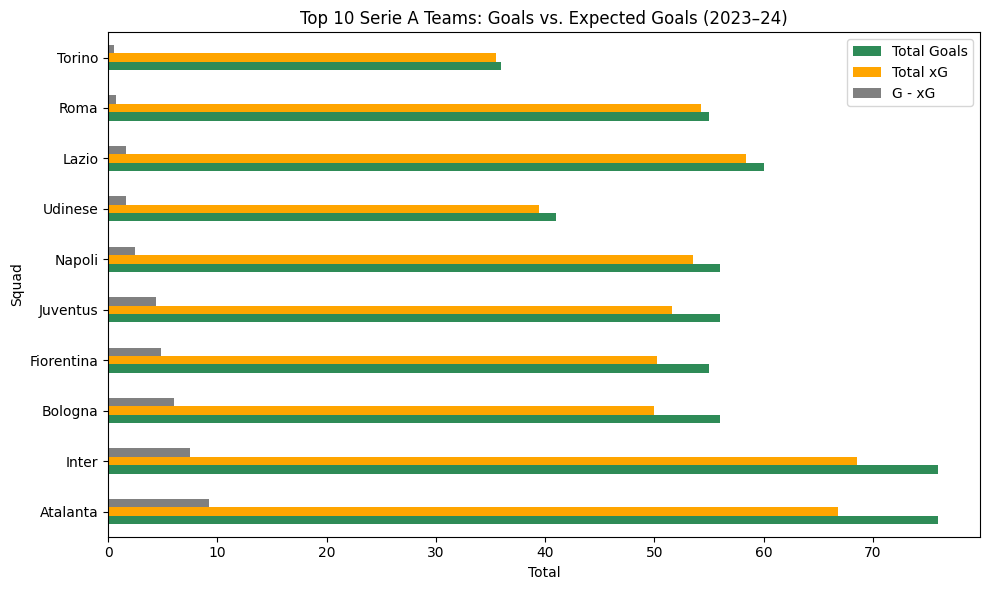

In [71]:
df_std['Expected_xG'] = pd.to_numeric(df_std['Expected_xG'], errors='coerce')
team_xg_performance = (
    df_std.groupby('Squad').apply(
        lambda x: pd.Series({
            'Total Goals': x['Performance_Gls'].sum(),
            'Total xG': x['Expected_xG'].sum(),
            'G - xG': x['Performance_Gls'].sum() - x['Expected_xG'].sum()
        })
    )
    .sort_values('G - xG', ascending=False)
    .head(10)
)
team_xg_performance[['Total Goals', 'Total xG', 'G - xG']].plot(
    kind='barh', figsize=(10,6), color=['seagreen', 'orange', 'gray']
)
plt.xlabel('Total')
plt.title('Top 10 Serie A Teams: Goals vs. Expected Goals (2023–24)')
plt.tight_layout()
plt.show()


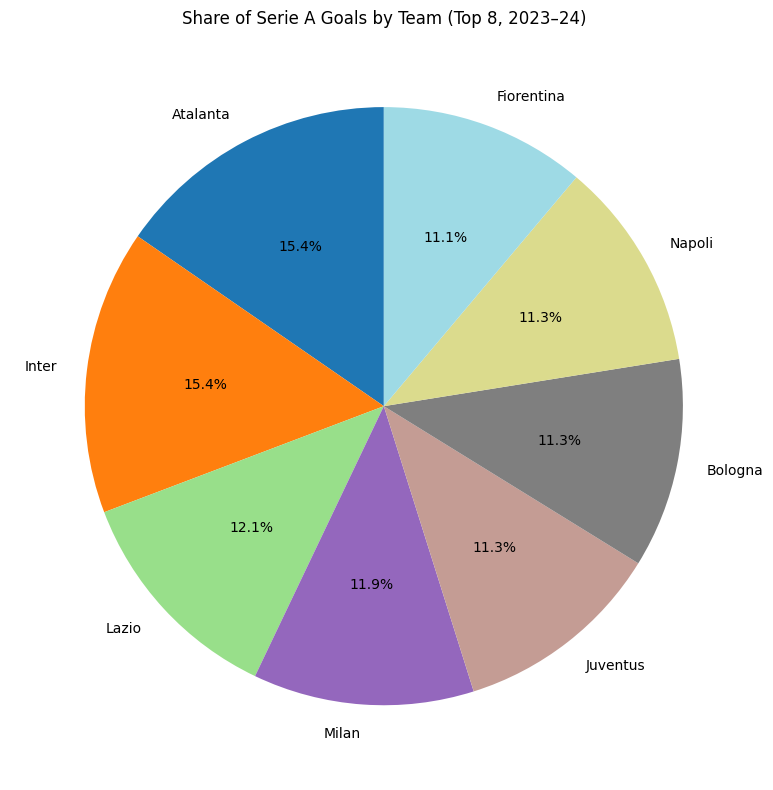

In [72]:
# Get total goals by team for all players
goals_by_team = (
    df_std.groupby('Squad')['Performance_Gls'].sum()
    .sort_values(ascending=False)
)
plt.figure(figsize=(8,8))
goals_by_team.head(8).plot(
    kind='pie', autopct='%1.1f%%', startangle=90, cmap='tab20', legend=False
)
plt.ylabel('')
plt.title('Share of Serie A Goals by Team (Top 8, 2023–24)')
plt.tight_layout()
plt.show()


In [75]:
df_all_conversion['xG'] = pd.to_numeric(df_all_conversion['Expected_xG'], errors='coerce')
df_all_conversion['xG_per_shot'] = df_all_conversion['xG'] / df_all_conversion['Shots']


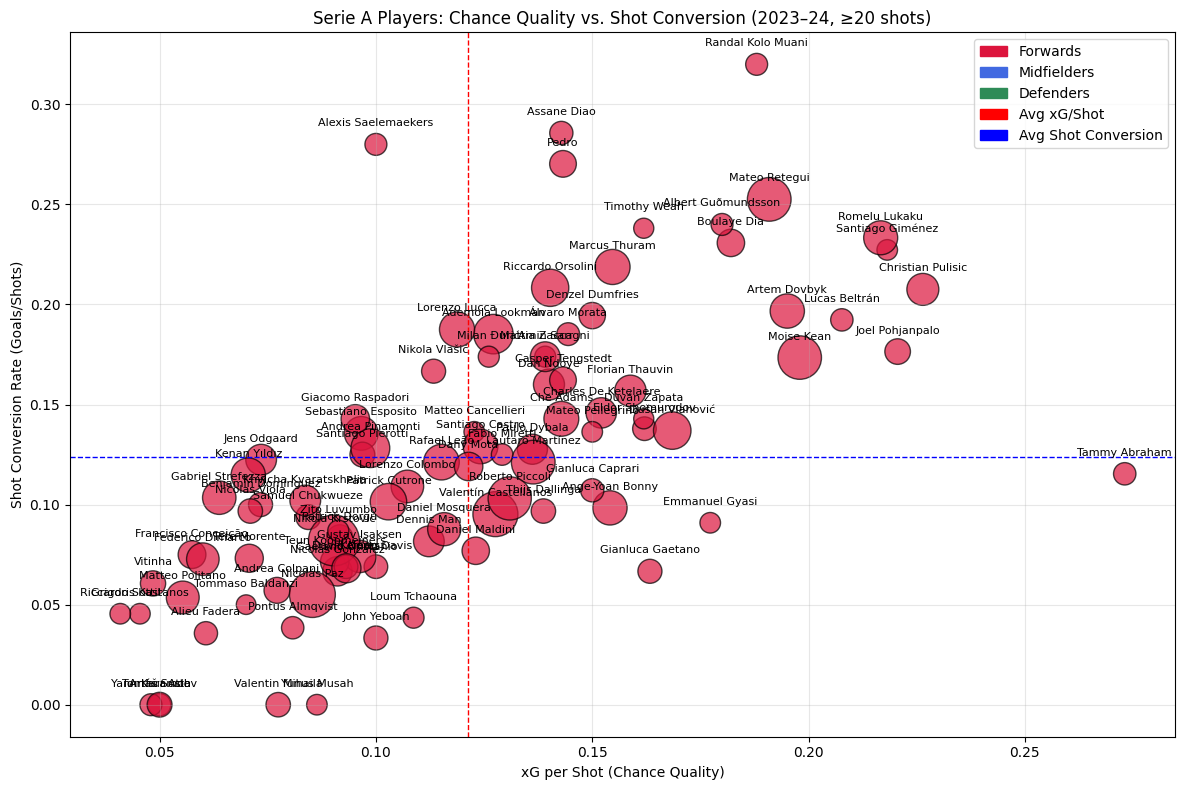

In [76]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd

# 1. Filter for players with at least 20 shots
df_all_conversion = df_merged[df_merged['Shots'] >= 20].copy()

# 2. Use the correct xG column
df_all_conversion['xG'] = pd.to_numeric(df_all_conversion['Expected_xG'], errors='coerce')
df_all_conversion['xG_per_shot'] = df_all_conversion['xG'] / df_all_conversion['Shots']

# 3. Color by position
def position_color(pos):
    if pd.isna(pos):
        return 'gray'
    if 'FW' in pos:
        return 'crimson'
    elif 'MF' in pos:
        return 'royalblue'
    else:
        return 'seagreen'
position_colors = df_all_conversion['Pos'].apply(position_color)

# 4. Plot
plt.figure(figsize=(12,8))
plt.scatter(
    df_all_conversion['xG_per_shot'],
    df_all_conversion['Shot_Conversion'],
    s=df_all_conversion['Shots']*10,
    alpha=0.7,
    c=position_colors,
    edgecolor='k'
)
for i, row in df_all_conversion.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.008,
        row['Player'],
        fontsize=8,
        ha='center',
        va='bottom'
    )
plt.axvline(df_all_conversion['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_all_conversion['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Players: Chance Quality vs. Shot Conversion (2023–24, ≥20 shots)')

# Custom legend for positions and avg lines
plt.legend(handles=[
    Patch(color='crimson', label='Forwards'),
    Patch(color='royalblue', label='Midfielders'),
    Patch(color='seagreen', label='Defenders'),
    Patch(color='red', label='Avg xG/Shot'),
    Patch(color='blue', label='Avg Shot Conversion')
])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


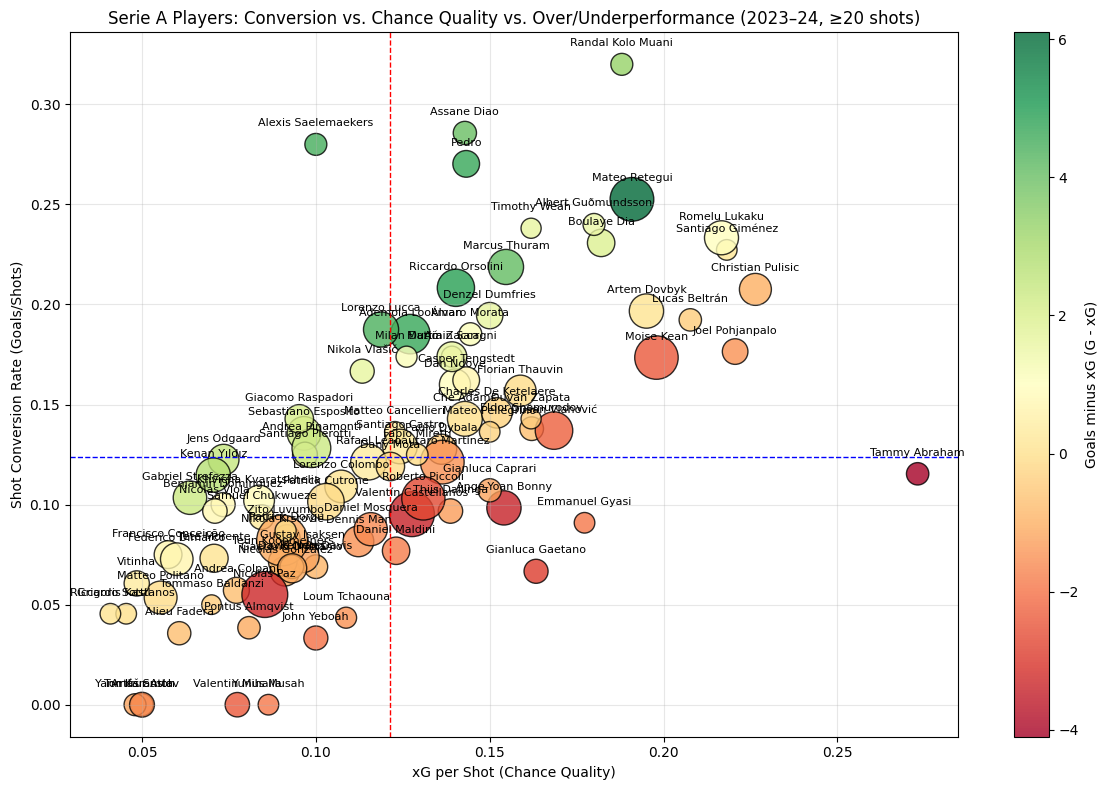

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the relevant columns exist and are numeric
df_all_conversion['xG'] = pd.to_numeric(df_all_conversion['Expected_xG'], errors='coerce')
df_all_conversion['G_minus_xG'] = df_all_conversion['Goals'] - df_all_conversion['xG']
df_all_conversion['xG_per_shot'] = df_all_conversion['xG'] / df_all_conversion['Shots']

plt.figure(figsize=(12,8))

# Use a diverging colormap for over/underperformance
cmap = plt.get_cmap('RdYlGn')
norm = plt.Normalize(df_all_conversion['G_minus_xG'].min(), df_all_conversion['G_minus_xG'].max())

# Scatter plot: color by G - xG
sc = plt.scatter(
    df_all_conversion['xG_per_shot'],
    df_all_conversion['Shot_Conversion'],
    s=df_all_conversion['Shots']*10,
    c=df_all_conversion['G_minus_xG'],
    cmap=cmap,
    norm=norm,
    alpha=0.8,
    edgecolor='k'
)

# Annotate
for i, row in df_all_conversion.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.008,
        row['Player'],
        fontsize=8,
        ha='center',
        va='bottom'
    )

plt.axvline(df_all_conversion['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_all_conversion['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Players: Conversion vs. Chance Quality vs. Over/Underperformance (2023–24, ≥20 shots)')

cbar = plt.colorbar(sc)
cbar.set_label('Goals minus xG (G - xG)')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
